# Datenanalyse ausprobieren, Japan erreichen

Big data ist in aller Munde. Um sich nicht zu verschlucken, fängt man vielleicht besser mit "little data" an.

Hier ein Beispiel für eine Datenanalyse.  Wir nutzen die Datenanalyse / "literate programming" - Umgebung [Jupyter](http://jupyter.org/). Dabei entsteht aus Markdown und Python ein ansprechendes Notebook.

In [1]:
# Auf den Schultern von Riesen wird man zur hochgestellten Persönlichkeit...
# Hier einige tragfähige "Riesen":

import pandas as pd  # Datenanalysesoftware
import numpy as np   # Numerische Software
import matplotlib as mpl
import matplotlib.pyplot as plt # Graphische Ausgabe

# Und unser eigener "calling Japan" Code:
import cj

## Das Problem

Die Amateurfunkstation DJ3EI mit einer Morsefunkverbindung Japan erreichen.

Für eine kleine Funkstation (nur 5 Watt Sendeleistung, provisorische Antenne) kein leichtes Unterfangen.

### Datenanalyse kann helfen

Ansatz: Die Nachteile der kleinen Station ausgleichen durch Datenanalyse.

Welchen Uhrzeit und auf welches Frequenzband sind erfolgversprechend?

### Monitoringdaten

Es gibt automatisch arbeitende Monitoring-Stationen.

Sie extrahieren aus empfangenen Morsezeichen den Absender und melden in eine zentrale Datenbank im Internet.
Das gesamte System nennt sich [Reverse Beacon Network](http://www.reversebeacon.net/) (RBN).

Das RBN stellt den Datenbankinhalt als eine ZIP-Datei pro Tag zur Verfügung,
die wir holen, auspacken und zusammenfassen.

In [2]:
# RBN stellt den Datenbankinhalt als eine ZIP-Datei pro Tag zur Verfügung,
# die wir holen, auspacken und zusammenfassen.

# Außer September werden noch zusätzlich einige Tage vom August und Oktober
# besorgt, um die Wochen im September komplett zu haben.

import calendar
import datetime

start = datetime.datetime.now()
df = cj.pull_rbn_month(2019, 9)
duration = (datetime.datetime.now() - start).total_seconds()
print("{} Zeilen eingelesen in {} Sekunden, also {:4.1f} µs/Zeile.".format(len(df), duration, duration * 1e6 / len(df)))

....................................... OK.
39 files input


8766695 Zeilen eingelesen in 33.959382 Sekunden, also  3.9 µs/Zeile.


### Wie sehen diese Daten aus?

In [3]:
df.head()

,callsign,de_pfx,de_cont,freq,band,dx,dx_pfx,dx_cont,mode,db,date,speed,tx_mode
0,N9YKE,K,NA,3546.8,80.0,N9ZXL,K,NA,CQ,5.0,2019-08-26,15.0,CW
1,N9YKE,K,NA,7057.0,40.0,W4JF,K,NA,CQ,11.0,2019-08-26,16.0,CW
2,K3PA,K,NA,7046.0,40.0,N4ARY,K,NA,CQ,24.0,2019-08-26,14.0,CW
3,N5RZ,K,NA,7046.0,40.0,N4ARY,K,NA,CQ,17.0,2019-08-26,14.0,CW
4,EA5WU,EA,EU,7009.0,40.0,LW2DOD,LU,SA,CQ,7.0,2019-08-26,22.0,CW


Dabei bedeuten:
    
* `callsign` Rufzeichen der empfangenden (an RBN meldenden) Station
* `de_pfx` Land der empfangenden Station
* `de_cont` Kontinent der empfangenden Station
* `dx`  Rufzeichen der sendenden (gemeldeten) Station
* `dx_pfx` Land der sendenden Station
* `dx_cont` Kontinent der sendenden Station
* `mode` Sendeart
* `db` Maß für die Signalstärke: dB über dem lokalen Rauschen beim Empfänger
* `date` Datum und Uhrzeit (UTC) - Uhrzeit wird hier nicht angezeigt, ist aber vorhanden
* `speed` Geschwindigkeit (bei Morsen und RTTY)
* `tx_mode` Sendeart

### Erster Überblick

Bei `band`, `mode` und `tx_mode` schauen wir mal, welche Werte es gibt und wie viele Messungen mit dem jeweiligen Wert:

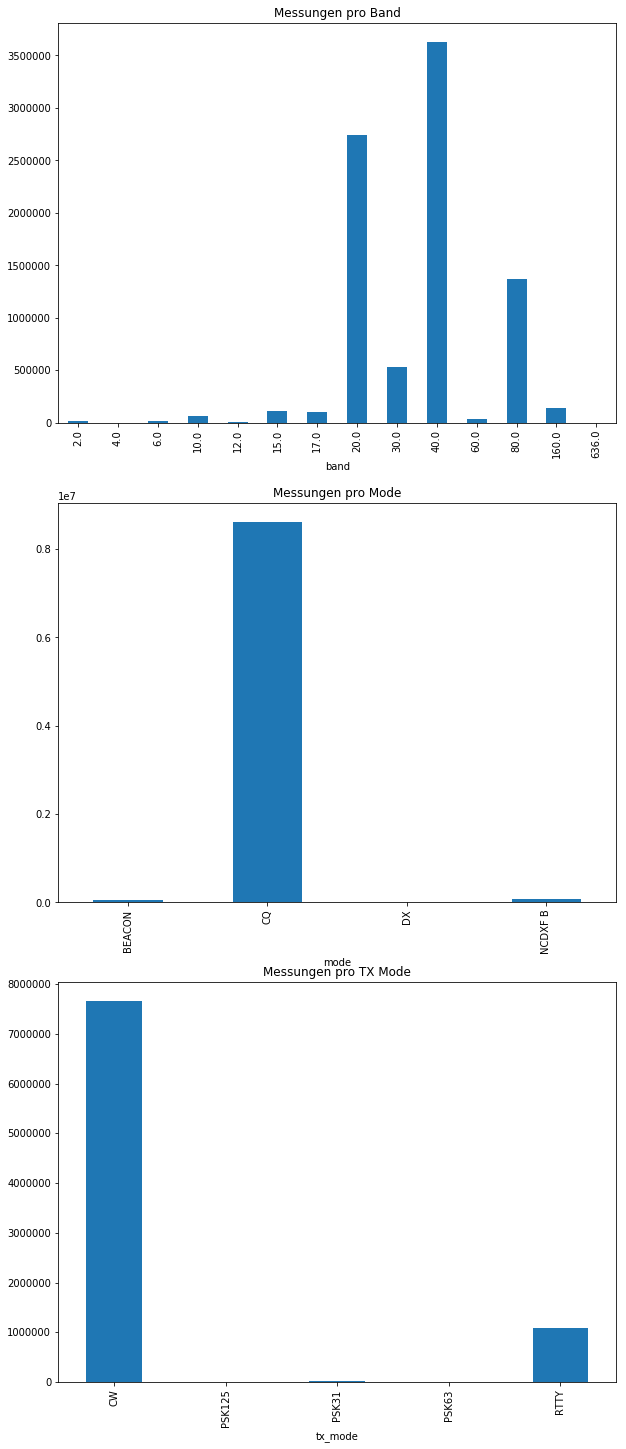

In [4]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = [10, 25])
df.groupby('band').count()['callsign'].plot(kind = "bar", title = "Messungen pro Band", ax = ax[0])
df.groupby('mode').count()['callsign'].plot(kind = "bar", title = "Messungen pro Mode", ax = ax[1])
df.groupby('tx_mode').count()['callsign'].plot(kind = "bar", title = "Messungen pro TX Mode", ax = ax[2])
plt.show()

## Japan auswählen

Interessant sind nur deutsche Stationen, die Japan gehört haben oder japanische, die deutsche gehört haben.

In [5]:
jatx = df[df['dx_pfx'] == 'JA']
ja2dl = jatx[jatx['de_pfx'] == 'DL']
dltx = df[df['dx_pfx'] == 'DL']
dl2ja = dltx[dltx['de_pfx'] == 'JA']
jade = pd.concat([ja2dl, dl2ja])

### Bänder für Verkehr mit Japan

Mal sehen, welche Bänder da funktionieren:

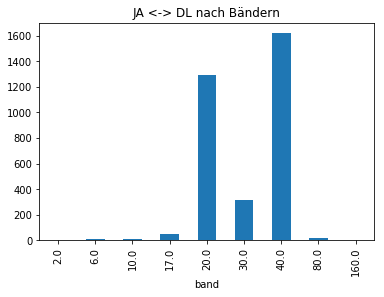

In [6]:
jade.groupby('band').count()['callsign'].plot(kind = "bar", title = "JA <-> DL nach Bändern");

Es ist etwas überraschend, dass 12m und 15 m - Band komplett fehlen.
Schöne Grüße vom Sonnenfleckenminimum, im Jahre 2023 wird das ganz anders aussehen.

Aber noch ist das Jahr 2019. Relevant ist derzeit vor allem das 20m - Band. In zweiter Linie
kommen 17m, 30m und 40m in Frage.

### Wann ist eine gute Zeit?

Die folgende Auswertung betrifft Uhrzeiten, in denen japanische Stationen CQ gerufen haben (was automatisch
arbeitende Stationen ausschließt) und von deutschen Stationen gehört wurden. Die Frage: Zu welchen Uhrzeiten?

1830

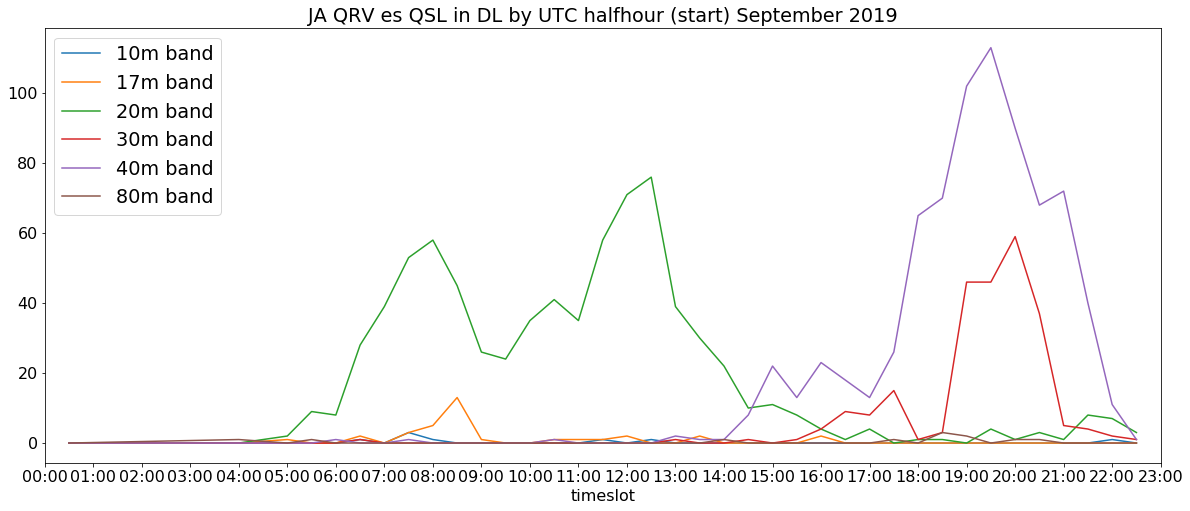

In [7]:

def ts2time_of_day(d):
    return datetime.time(hour = d.hour, minute = (d.minute // 30) * 30)

def band2name(band):
    return "{0}m band".format(band)

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

xticks_values = [datetime.time(hour = h) for h in range(0,24)]
bands = [band2name(band) for band in [10, 17, 20, 30, 40, 80]]
ja2dlcq = ja2dl[ja2dl['mode'] == 'CQ'].copy()
for band in [10, 17, 20, 30, 40, 80]:
    ja2dlcq.loc[ja2dlcq['band'] == float(band), band2name(band)] = 1
ja2dlcq.loc[:, 'timeslot'] = ja2dlcq['date'].map(ts2time_of_day)
ja2dlcq.loc[:, ['timeslot'] + bands] \
    .groupby(['timeslot']).sum() \
    .plot(kind = "line", title = "JA QRV es QSL in DL by UTC halfhour (start) September 2019", \
          xticks = xticks_values, figsize = [20, 8], use_index = True)
len(ja2dlcq)

Im Herbst ändern sich die Bedingungen durch den geänderten Sonnenstand besonders schnell.

Schauen wir mal, ob die Uhrzeiten anders ausfallen, wenn wir statt September und Oktober
nur die Daten der letzten Woche benutzen:

642

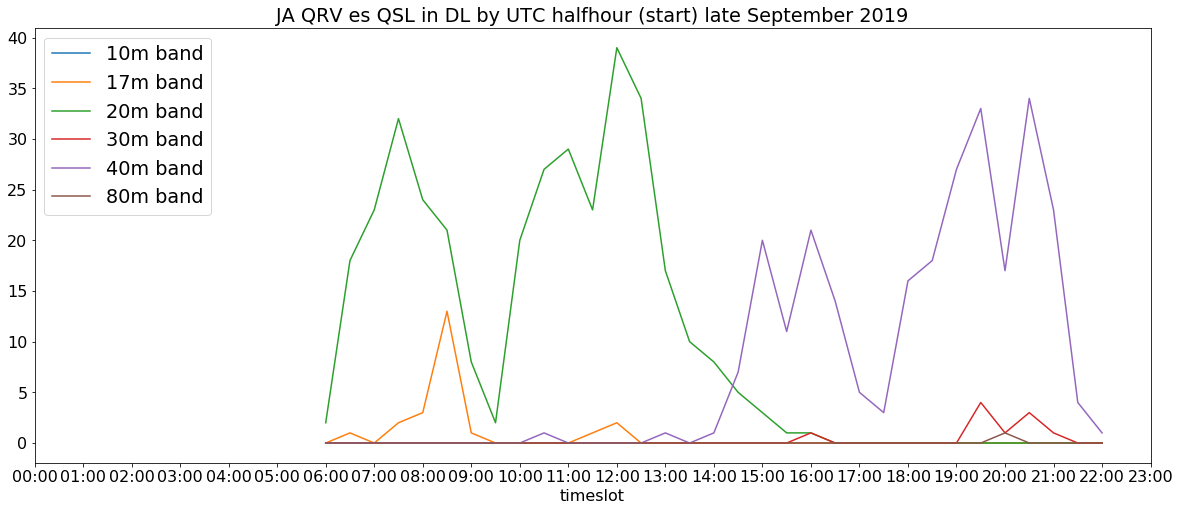

In [8]:
ja2dlcq = ja2dl[ja2dl['mode'] == 'CQ'].copy()
# ja2dlcqlate = ja2dl[ for t in ja2dlcq['date']]
fr = datetime.datetime(2019, 9, 23)
to = datetime.datetime(2019, 9, 30)
ja2dlcq_late = ja2dlcq[[fr < t and t <= to for t in ja2dlcq['date']]].copy()
for band in [10, 17, 20, 30, 40, 80]:
    ja2dlcq_late.loc[ja2dlcq_late['band'] == float(band), band2name(band)] = 1
ja2dlcq_late.loc[:, 'timeslot'] = ja2dlcq_late['date'].map(ts2time_of_day)
ja2dlcq_late.loc[:, ['timeslot'] + bands] \
    .groupby(['timeslot']).sum() \
    .plot(kind = "line", title = "JA QRV es QSL in DL by UTC halfhour (start) late September 2019", \
          xticks = xticks_values, figsize = [20, 8], use_index = True)
len(ja2dlcq_late)

Das sieht so aus, als wenn die Bedingungen sich im Laufe des September
signifikant geändert hätten.  Um das zu überprüfen folgt
eine Auswertung aller JA-DL-Kontakte (beide Richtungen) pro Kalenderwoche,
getrennt nach CW und RTTY. Man erkennt deutlich den RTTY-Contest, aber vor allem
die steigende Tendenz der 20m-Aktivität.

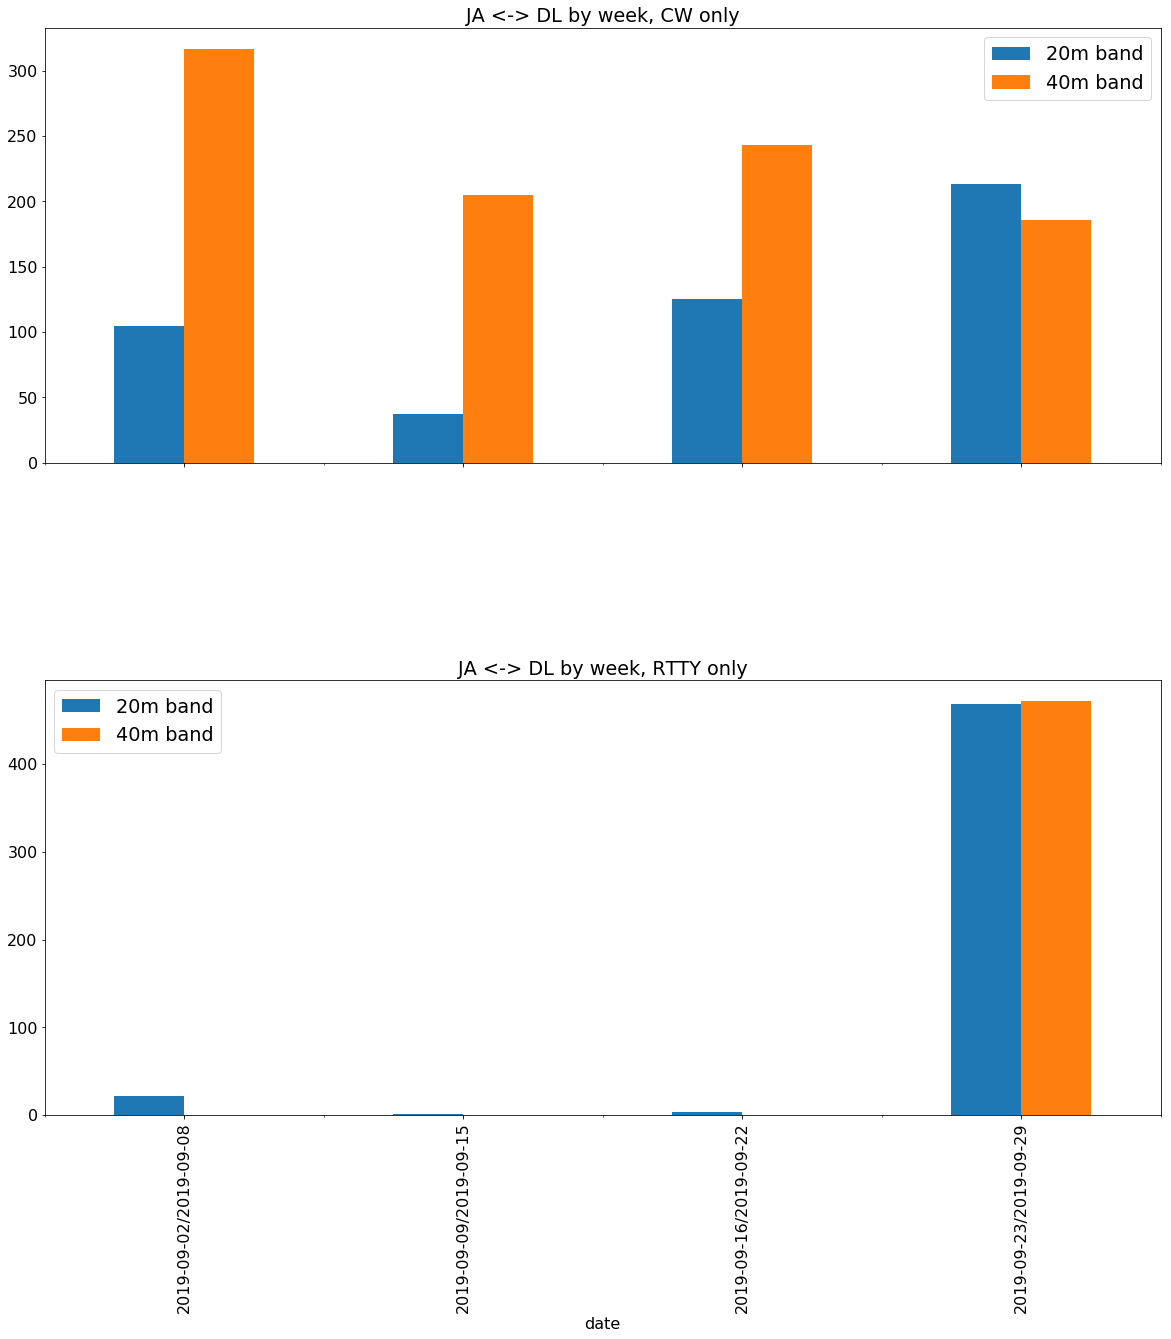

In [9]:
# for band in [17, 20, 30, 40]:
#    jade.loc[jade['band'] == float(band), band2name(band)] = 1
jade2040 = jade[[b == float(20) or b == float(40) for b in jade['band']]].copy()
for band in [20, 40]:
    jade2040.loc[jade2040['band'] == float(band), band2name(band)] = 1

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = [20, 30], sharex = True, gridspec_kw = {"hspace": 0.5})
bands = [band2name(band) for band in [20, 40]]

jade2040.loc[jade2040['tx_mode'] == 'CW', ['date'] + bands].groupby('date').sum().to_period(freq = 'W').groupby('date').sum()\
    .plot(kind = "bar", title = "JA <-> DL by week, CW only", \
          figsize = [20, 20], use_index = True, ax = ax[0])
jade2040.loc[jade2040['tx_mode'] == 'RTTY', ['date'] + bands].groupby('date').sum().to_period(freq = 'W').groupby('date').sum()\
    .plot(kind = "bar", title = "JA <-> DL by week, RTTY only", \
          figsize = [20, 20], use_index = True, ax = ax[1])
plt.show()